In [539]:
import os

import pandas as pd
import numpy as np
import scipy.optimize as opt
import matplotlib
pd.set_option('display.float_format', lambda x: '%.6f' % x)

def sample_cov(r, **kwargs):
    """
    Returns the sample covariance of the supplied returns
    """
    return r.cov()

def portfolio_returns(weights, returns):
    '''
    Weights --> Returns
    '''
    return weights.T @ returns


def portfolio_vol(weights, covmat):
    '''
    Weights --> Vol
    '''
    return (weights.T @ covmat @ weights) ** 0.5

def minimise_vol(er, cov):
    '''
    target_return --> W
    '''
    n = er.shape[0]
    init_guess = np.repeat(1 / n, n)
    # bounds = ((0.0, 1.0),) * n

    weights_sum_to_1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }
    results = opt.minimize(portfolio_vol, init_guess, args=(cov,), method='SLSQP',
                           options={'disp': False},
                           constraints=weights_sum_to_1
                           # bounds=bounds
                           )
    return results.x

def target_return_minimise_vol(target_return, er, cov):
    '''
    target_return --> W
    '''
    n = er.shape[0]
    init_guess = np.repeat(1 / n, n)
    # bounds = ((0.0, 1.0),) * n
    return_is_target = {
        'type': 'eq',
        'args': (er,),
        'fun': lambda weights, er: target_return - portfolio_returns(weights, er)
    }
    weights_sum_to_1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }
    results = opt.minimize(portfolio_vol, init_guess, args=(cov,), method='SLSQP',
                           options={'disp': False},
                           constraints=(weights_sum_to_1, return_is_target)
                           # bounds=bounds
                           )
    return results.x

def msr(riskfree_rate, er, cov):
    '''
    RiskFree rate + ER + COV --> W
    '''
    n = er.shape[0]
    init_guess = np.repeat(1 / n, n)
    # bounds = ((0.0, 1.0),) * n
    weights_sum_to_1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }

    def negative_sharpe_ratio(weights, riskfree_rate, er, cov):
        '''
        Returns the negative of the sharpe ratio, given weights
        '''
        r = portfolio_returns(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate) / vol

    results = opt.minimize(negative_sharpe_ratio,
                       init_guess,
                       args=(riskfree_rate, er, cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1)
                       # bounds=bounds
                       )
    return results.x

def optimal_weights(n_points, er, cov):
    '''
    --> list of weights to run the optimiser on to minimise the vol
    '''
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [target_return_minimise_vol(target_return, er, cov) for target_return in target_rs]
    return weights

def plot_ef(n_points, er, cov, style=".-", show_cml=False, riskfree_rate=0, show_ew=False, show_gmv=False):
    '''
    Plots the n asset efficient frontier
    '''

    #     weights = [np.array([w, 1-w]) for w in np.linspace(0,1,n_points)]
    weights = optimal_weights(n_points, er, cov)
    rets = [portfolio_returns(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets,
        "Volatility": vols
    })
    ax = ef.plot.line(x="Volatility", y="Returns", style=style)
    if show_cml:
        ax.set_xlim(left=0)
        w_msr = msr(riskfree_rate, er, cov)
        r_msr = portfolio_returns(w_msr, er)
        vol_msr = portfolio_vol(w_msr, cov)
        # Add CML
        cml_x = [0, vol_msr]
        cml_y = [riskfree_rate, r_msr]
        ax.plot(cml_x, cml_y, color="green", marker="o", linestyle="dashed", markersize=12, linewidth=2)
    if show_gmv:
        w_gmv = gmv(cov)
        r_gmv = portfolio_returns(w_gmv, er)
        vol_gmv = portfolio_vol(w_gmv, cov)
        ax.plot([vol_gmv], [r_gmv], color="midnightblue", marker="o", markersize=10)
    if show_ew:
        n = er.shape[0]
        w_ew = np.repeat(1 / n, n)
        r_ew = portfolio_returns(w_ew, er)
        vol_ew = portfolio_vol(w_ew, cov)
        ax.plot([vol_ew], [r_ew], color='goldenrod', marker="o", markersize=10)
    return ax

### Question 1
Please download the Excel spread sheet "Assignment 1", and then solve questions

Compute the mean return on the portfolio $x=\frac{1}{3}(1, 1, 1)$ consisting of only the risky assets.

Submission Guideline: Give your answer in % rounded to 2 decimal places. For example, if you compute the answer to be 2.67%, submit 2.67.

The file attached below provides excel instructions if needed.

In [540]:
n = 3
wt = np.ones(n) / n
rf = 0.01
rets = np.array([0.06, 0.02, 0.04])
vols = np.array([8.94/100, 4.47/100, 8.94/100])
covmat = np.array([[0.00800,	-0.00200, 0.00400], [-0.00200, 0.00200, -0.00200], [0.00400,-0.00200, 0.00800]])
portfolio_rets = portfolio_returns(weights=wt, returns=rets)
print(f"The portfolio return of equal weight portfolio is {np.round(portfolio_rets*100, 2)}%")


The portfolio return of equal weight portfolio is 4.0%


### Question 2
Compute the volatility of the return on the portfolio $x=\frac{1}{3}(1, 1, 1)$ consisting only of the risky assets (i.e. same portfolio as Question 1).

Submission Guideline: Give your answer in % rounded to 2 decimal places. For example, if you compute the answer to be 2.67%, submit 2.67.

In [541]:
portfolio_vols = portfolio_vol(weights=wt, covmat=covmat)
print(f"The portfolio vol of equal weight portfolio is {np.round(portfolio_vols* 100, 2)}%")


The portfolio vol of equal weight portfolio is 4.47%


### Question 3
Compute the mean return on the minimum variance portfolio of just the risky assets.

The minimum variance portfolio is defined as the portfolio of risky assets that has the least volatility among all possible portfolios of just the risky assets. This portfolio is the solution to the optimization problem
$min \ \sigma_{x}^2$  $ = $  $min \ x^TVx $
$s.t \ \sum_{i=1}^d \ x_i = 1$  $s.t \ \sum_{i=1}^d \ x_i = 1$


In the data sheet in the workbook Assignment1.xlsx we have set up all the relevant variables - you just have to set up and solve the optimization problem. In particular, you have to set the objective to minimize volatility cell B24 with only the portfolio constraint J20=L20.

Submission Guideline: Give your answer in % rounded to 2 decimal places. For example, if you compute the answer to be 2.67%, submit 2.67.

In [542]:
min_vol_wts = np.round(minimise_vol(er=rets, cov=covmat), 2)
min_vol_port_return = portfolio_returns(weights=min_vol_wts, returns=rets)
min_vol_port = portfolio_vol(weights=min_vol_wts, covmat=covmat)

print(f"The mean return is {np.round(min_vol_port_return* 100, 2)}% on the minimum vol of {np.round(min_vol_port* 100, 2)}%")
min_vol_port

The mean return is 3.04% on the minimum vol of 2.61%


0.026080644163823868

### Question 4
Compute the mean return on the Sharpe optimal portfolio for this market.

Recall that we can compute the Sharpe optimal portfolio by taking only the risky positions and re-scaling them so that the components add up to 1. This procedure can be done by using the functions in following worksheet "Sheet 1". Another way to compute the Sharpe portfolio is to use the formulas of the Sharpe portfolio.

Submission Guideline: Give your answer in % rounded to 2 decimal places. For example, if you compute the answer to be 2.67%, submit 2.67

### Question 5
Compute the volatility of the Sharpe optimal portfolio for this market.

Recall that we can compute the Sharpe optimal portfolio by taking the risky positions corresponding to any risk aversion parameter and re-scaling them so that the components add up to 1.

Submission Guideline: Give your answer in % rounded to 2 decimal places. For example, if you compute the answer to be 2.67%, submit 2.67.




In [543]:
msr_port_wt = np.round(msr(riskfree_rate=rf, er=rets, cov=covmat), 3)
msr_port_return = portfolio_returns(weights=msr_port_wt, returns=rets)
msr_port_vol = portfolio_vol(weights=msr_port_wt, covmat=covmat)
print(f"The MSR mean return is {np.round(msr_port_return* 100, 2)}% on the minimum vol of {np.round(msr_port_vol* 100, 2)}%")

The MSR mean return is 3.42% on the minimum vol of 2.84%


### Question 6
Using the results in the previous question, compute the slope of the capital market line.

Submission Guideline: Give your answer rounded to 2 decimal places. For example, if you compute the answer to be 2.67123, submit 2.67.

### Notes
The portfolio $s^*$ is the Maximum Sharpe Ration portfolio whose angle $\theta$ is maximum hence $tan(\theta) = \frac{MSR\ Expected\ Excess\ Return}{MSR\ Volatility}$


In [544]:
msr_excess_return = msr_port_return - rf
theta_angle = msr_excess_return/msr_port_vol
print(f"The slope of CML is {np.round(theta_angle, 2)} ")

The slope of CML is 0.85 


### Question 7

Suppose the volatility of an efficient investment opportunity is $\sigma = 5\%$ What is the return on this opportunity?

Recall that the mean return and volatility of all efficient investment opportunities must lie on the capital market line.

Submission Guideline: Give your answer in % rounded to 2 decimal places. For example, if you answer the return to be 2.67%, submit 2.67.

In [545]:
given_vol = 5/100
return_given_vol = theta_angle * given_vol
print(f"The Efficient Return given {np.round(given_vol* 100, 2)}% Vol is {np.round((return_given_vol + rf)*100, 2)}%")

The Efficient Return given 5.0% Vol is 5.26%


In [546]:
script_dr = os.getcwd()
df = pd.read_excel(os.path.abspath(os.path.join(script_dr, '..', 'Data', 'FERM_3_Assignment_1.xlsx')), sheet_name='Daily_Returns_Q1_Q2')
df

,date,IBM,GE,LLY,F,BAC,KR,ITUB,GG,SIRI,...,T,ECA,ABEV,CVS,MRVL,CSCO,MO,BMY,WFC,HBAN
0,2016-01-04,-0.000736,0.000976,0.014852,-0.018058,0.000000,0.022343,0.008006,-0.023029,-0.010178,...,0.006963,0.026925,0.013954,0.002899,-0.032335,-0.004554,0.020011,0.019501,-0.000378,0.001867
1,2016-01-05,-0.005018,-0.016069,-0.006321,-0.045479,-0.021533,-0.000951,-0.008006,0.018804,-0.005128,...,-0.015441,-0.062643,-0.011614,-0.012273,-0.056744,-0.010708,0.010534,-0.017713,-0.019281,-0.015985
2,2016-01-06,-0.017237,-0.043235,-0.026306,-0.031773,-0.036736,-0.023581,-0.031023,0.074229,-0.012937,...,-0.016280,-0.049700,-0.040530,-0.014546,0.009889,-0.023338,-0.017561,-0.028090,-0.028942,-0.030801
3,2016-01-07,-0.009301,-0.018113,-0.001967,-0.012678,-0.019545,-0.006596,0.000000,-0.018247,-0.007843,...,0.000895,0.037504,0.016888,-0.006605,0.011009,-0.025106,0.001719,-0.025754,-0.016807,-0.017752
4,2016-01-08,0.012082,0.004559,-0.012135,0.018175,0.007211,0.011696,-0.001660,-0.055982,0.002621,...,0.012150,-0.035384,-0.016888,0.014431,0.012092,0.019581,0.020731,-0.010268,0.010637,0.004963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,2017-12-21,0.006579,0.001716,-0.006328,-0.003967,0.002010,0.025091,-0.006211,0.007981,0.018798,...,0.001542,0.004773,0.001596,-0.016616,-0.001816,0.000519,0.002776,-0.008819,-0.000974,-0.004051
498,2017-12-22,0.002162,-0.004008,-0.000941,0.001589,-0.003352,-0.016057,0.004662,0.011067,0.009268,...,0.003077,0.039678,0.012678,0.003671,-0.007754,-0.001817,-0.000832,0.004909,-0.006847,-0.010201
499,2017-12-26,0.001961,-0.002873,0.001763,-0.007968,-0.001680,-0.003243,-0.006221,-0.003150,-0.005550,...,-0.004362,0.001524,0.003145,-0.012565,0.009569,0.002077,0.004844,0.006833,-0.002949,-0.002738
500,2017-12-27,0.005925,-0.001151,-0.001058,0.006380,0.002352,-0.002168,0.008544,0.002363,-0.001857,...,0.007429,0.014367,0.007819,0.003978,-0.007283,0.000778,-0.016145,0.001458,0.005726,0.010228


### Question 1
A file of the stocks daily returns (Calculated as $\frac{P_{i+1} - P_i}{P_i}$) from January 4th 2016- December 28th 2017 is provided below. Please download this file to answer the questions.

There are 23 stocks' daily returns from January 4th, 2016 to December 28th, 2017 from Yahoo Finance. Suppose these 23 stocks are the only risky assets available in the market. Please compute the mean daily returns of each stock, and the covariance matrix of those stocks' returns. Please enter the average daily return of Stock 'GE' from from January, 4th 2016 to December 28th, 2017. (Round to the fourth decimal place.)

In [547]:
ticker = 'GE'
df[ticker].mean()
print(f"The Average daily return of {ticker} is {np.round(df[ticker].mean(), 4)}")

The Average daily return of GE is -0.0011


### Question 2
Continued from Question 1

Please enter the covariance between daily returns of IBM and GE from from January, 4th 2016 to December 28th, 2017. (Round to the sixth decimal place.)


In [548]:
tics = ['IBM', 'GE']
cov = sample_cov(df[tics])[tics[0]][tics[1]]
print(f"The covariance between {tics[0]} and {tics[1]} is {np.round(cov, 6)}")

The covariance between IBM and GE is 4.7e-05


### Question 3
Continued from Question 2

Suppose we want to minimize the risk of the portfolio with the constraint that average daily return should be greater than or equal to 0.05%. i.e. :
$minimise\ x^TVx$
$s.t. \mu^Tx\ > 0.0005$
$1^Tx = 1$
where $\mu$ is the daily return vector of stocks, x is weight vector of stocks in the portfolio, and V is the covariance matrix of stocks daily return
What is the optimal value?
Let $x_1$ be your optimal portfolio in this problem

### Question 4
Continued from Question 3

What is the expected return of the portfolio $x_1$? (Round your answer to the fourth decimal place.)

Think about if it is greater than 0.05%, smaller than 0.05% or equal to 0.05%.


In [549]:
target_return_x1 = 0.0005
cov = sample_cov(df)
returns = df.mean()
weights1 = target_return_minimise_vol(target_return=target_return_x1, er=returns, cov=cov)
portfolio_ret1 = portfolio_returns(weights=weights1, returns=returns)
portfolio_vol1 = portfolio_vol(weights=weights1, covmat=cov)
x1= portfolio_vol1**2

print(f"The optimal portfolio variance is {x1} with target return of {target_return_x1} is {np.round(portfolio_ret1, 4)}")

/var/folders/gw/hq2jnpl90jjfpr7ymdkq6k580000gn/T/ipykernel_21088/2615507740.py:13: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return r.cov()
/var/folders/gw/hq2jnpl90jjfpr7ymdkq6k580000gn/T/ipykernel_21088/661419433.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  returns = df.mean()


The optimal portfolio variance is 3.329176913853645e-05 with target return of 0.0005 is 0.0005


### Question 5
Continued from Question 4

Suppose we now want to change the previous constraint so that the average daily return should be greater than or equal to 0.08%.

What is the new optimal value of the problem? (Round your solution to the sixth decimal place.) Let $x_2$ be your optimal portfolio in this problem.


In [550]:
target_return_x2 = 0.0008
weights2 = target_return_minimise_vol(target_return=target_return_x2, er=returns, cov=cov)
portfolio_ret2 = portfolio_returns(weights=weights2, returns=returns)
portfolio_vol2 = portfolio_vol(weights=weights2, covmat=cov)
x2 = portfolio_vol2**2

print(f"The optimal portfolio variance is {np.round(x2, 6)} with target return of {target_return_x2} is {np.round(portfolio_ret2, 4)}")

The optimal portfolio variance is 3.8e-05 with target return of 0.0008 is 0.0008


### Question 6
Suppose we now want to change the previous constraint so that the average daily return should be greater than or equal to 0.1%.

Solve for the optimal solution $x_3$ by solving the mean variance problem.

Compute $z = \phi x_1 + (1-\phi) x_2$ where $\phi = \frac{0.08\% - 0.1\%}{0.08\% - 0.05\%}$

Compare $z$ and $x_3$, test two fund theorem:

In [551]:
target_return_x3 = 0.001
phi = (target_return_x2 - target_return_x3)/(target_return_x2 - target_return_x1)
z = phi * x1 + (1-phi)*x2
weights3 = target_return_minimise_vol(target_return=target_return_x3, er=returns, cov=cov)
portfolio_ret3 = portfolio_returns(weights=weights3, returns=returns)
portfolio_vol3 = portfolio_vol(weights=weights3, covmat=cov)
x3 = portfolio_vol3**2
diff = z - x3
verdict ='Same' if abs(diff) > 0.0000001 else 'Not Same'
print(f"The z and x3 is {verdict}")

The z and x3 is Same


### Question 9
Assume the risk free rate of daily return $r_f = 0.01\%$. We want to maximize the Sharpe ratio problem:
$minimise  \frac{(\mu- r_f)^T x}{sqrt{(x^TVx)}}$
$s.t. 1^Tx = 1$
The problem is now equivalent to maximize the return of unit risk, which is also called the market price of risk.  We can rewrite maximization of the Sharpe ratio as minimizing the risk of unit return.
$minimise x^TVx$
$s.t.(\mu - r_f)^Tx = 1$
Now the $x$ from the optimal solution is no longer the weight vector of our portfolio.

So our sharp portfolio should be
$x_{sharpe}^* = \frac{x}{1^T x}$

Compute the Sharpe ratio for these stocks and round your answer to the  third decimal place.


In [552]:
risk_free = 0.01/100
msr_port_wt1 = np.round(msr(riskfree_rate=risk_free, er=returns, cov=cov), 3)
msr_port_return1 = portfolio_returns(weights=msr_port_wt1, returns=returns)
msr_port_vol1 = portfolio_vol(weights=msr_port_wt1, covmat=cov)
print(f"The MSR mean return is {np.round(msr_port_return* 100, 2)}% on the minimum vol of {np.round(msr_port_vol* 100, 2)}%")
# print(msr_port_return1, msr_port_vol1)

sharpe_ratio = (msr_port_return1 - risk_free)/msr_port_vol1
print(f"The sharpe ratio is the portfolio is {np.round(sharpe_ratio, 3)}")


The MSR mean return is 3.42% on the minimum vol of 2.84%
The sharpe ratio is the portfolio is 0.26


### When Market Performs Badly

In this part, the market has a very low yearly return. The Capital Asset Pricing Model will give you a negative Sharpe Ratio and the Capital Market Line will have a negative slope.  In this situation, how will you interpret the results from CAPM?  Will you still invest in the Sharpe optimal portfolio?

We are going to explore the limitations of simple Mean-Variance optimization models with a use case from stocks data from January 1st 2018 to January 1st 2019. You will discuss how to approach more complicated scenarios in the real world.

Think about the following questions:

Compute average daily returns and covariance matrix for those risky assets.

Get the efficient frontier of the market.

Compute Sharpe optimal portfolio and draw the Capital Market Line.

Compare the risk free rate and the return of Sharpe optimal portfolio.

You will find that the Sharpe optimal portfolio has a lower return but a higher risk than the risk free asset. Does CAPM show you an arbitrage opportunity?

Is it reasonable to use average daily return and sample covariance to be the parameters of CAPM?  How will you fine-tune the parameters?

In [553]:
ndf = pd.read_csv(os.path.abspath(os.path.join(script_dr, '..', 'Data', 'stock_returns_2018.csv')))
r_2018 = ndf.mean()
cov_2018 = sample_cov(ndf)
cov_2018

/var/folders/gw/hq2jnpl90jjfpr7ymdkq6k580000gn/T/ipykernel_21088/1959044954.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  r_2018 = ndf.mean()
/var/folders/gw/hq2jnpl90jjfpr7ymdkq6k580000gn/T/ipykernel_21088/2615507740.py:13: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return r.cov()


,IBM,GE,LLY,F,BAC,KR,ITUB,GG,SIRI,ACB,...,T,ECA,ABEV,CVS,MRVL,CSCO,MO,BMY,WFC,HBAN
IBM,0.000249,0.000134,0.000081,0.000087,0.000117,0.000049,0.000086,0.000005,0.000096,0.000130,...,0.000077,0.000112,0.000066,0.000104,0.000142,0.000154,0.000055,0.000083,0.000093,0.000086
GE,0.000134,0.000626,0.000067,0.000118,0.000125,0.000048,0.000023,0.000029,0.000068,0.000014,...,0.000072,0.000212,0.000036,0.000080,0.000096,0.000107,0.000088,0.000038,0.000075,0.000086
LLY,0.000081,0.000067,0.000203,0.000075,0.000097,0.000075,0.000090,-0.000044,0.000041,0.000011,...,0.000083,0.000126,0.000057,0.000112,0.000074,0.000117,0.000073,0.000115,0.000091,0.000090
F,0.000087,0.000118,0.000075,0.000307,0.000125,0.000069,0.000085,-0.000017,0.000083,0.000113,...,0.000092,0.000160,0.000047,0.000088,0.000109,0.000103,0.000083,0.000057,0.000104,0.000119
BAC,0.000117,0.000125,0.000097,0.000125,0.000246,0.000075,0.000108,0.000000,0.000094,0.000099,...,0.000090,0.000156,0.000081,0.000132,0.000161,0.000165,0.000051,0.000099,0.000180,0.000181
KR,0.000049,0.000048,0.000075,0.000069,0.000075,0.000443,0.000092,-0.000014,0.000041,0.000107,...,0.000072,0.000137,0.000060,0.000135,0.000021,0.000092,0.000090,0.000043,0.000086,0.000096
ITUB,0.000086,0.000023,0.000090,0.000085,0.000108,0.000092,0.000581,0.000074,0.000106,0.000083,...,0.000060,0.000065,0.000293,0.000098,0.000122,0.000105,0.000072,0.000097,0.000105,0.000078
GG,0.000005,0.000029,-0.000044,-0.000017,0.000000,-0.000014,0.000074,0.000578,-0.000002,0.000098,...,0.000018,0.000019,0.000123,-0.000023,0.000034,-0.000013,-0.000021,0.000012,-0.000018,-0.000036
SIRI,0.000096,0.000068,0.000041,0.000083,0.000094,0.000041,0.000106,-0.000002,0.000270,0.000108,...,0.000051,0.000102,0.000096,0.000082,0.000169,0.000131,0.000041,0.000074,0.000087,0.000084
ACB,0.000130,0.000014,0.000011,0.000113,0.000099,0.000107,0.000083,0.000098,0.000108,0.003354,...,0.000039,0.000273,0.000060,0.000059,0.000167,0.000158,0.000048,0.000027,0.000058,0.000070


In [554]:
risk_free = 0.01/100
msr_port_wt2018 = np.round(msr(riskfree_rate=risk_free, er=r_2018, cov=cov_2018), 3)
msr_port_return2018 = portfolio_returns(weights=msr_port_wt2018, returns=returns)
msr_port_vol2018 = portfolio_vol(weights=msr_port_wt2018, covmat=cov_2018)
print(f"The MSR mean return is {np.round(msr_port_return2018* 100, 2)}% on the minimum vol of {np.round(msr_port_vol2018* 100, 2)}%")
# print(msr_port_return1, msr_port_vol1)

sharpe_ratio = (msr_port_return2018 - risk_free)/msr_port_vol2018
print(f"The sharpe ratio is the portfolio is {np.round(sharpe_ratio, 3)}")
msr_port_wt2018

The MSR mean return is 143.44% on the minimum vol of 21020.04%
The sharpe ratio is the portfolio is 0.007


array([-2328.37 , -1740.254,  8702.201, -2646.876,   349.002,   856.628,
        1344.421,  2130.622,  6231.148,  -550.319,  3156.764,  7017.031,
        -296.454, -2460.532, -2304.12 , -7732.224, -1661.205, -3290.328,
        4437.858, -1988.181, -3554.105, -3546.388,  -125.32 ])

<Axes: xlabel='Volatility'>

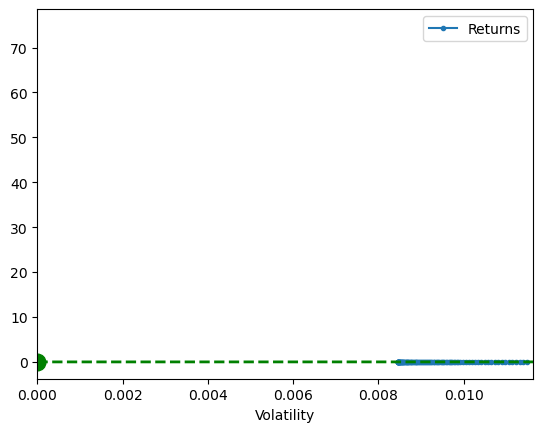

In [555]:
plot_ef(n_points=100, er=r_2018, cov=cov_2018, show_cml=True, riskfree_rate=risk_free)